<a href="https://colab.research.google.com/github/azimhims/azimhims/blob/main/Pretrain_Assignment_Utkface1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# need to upload datasets from kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 97% 322M/331M [00:03<00:00, 122MB/s]
100% 331M/331M [00:03<00:00, 92.2MB/s]


In [4]:
import zipfile

In [5]:
with zipfile.ZipFile('/content/utkface-new.zip','r') as zip_ref:
  zip_ref.extractall('/content')

In [6]:
import os
import keras
import tensorflow
import numpy as np
import pandas as pd
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator





In [7]:
tensorflow.config.run_functions_eagerly(True)

In [8]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'
folder = '/content/utkface_aligned_cropped/'

In [9]:
data = os.listdir(folder_path)

In [25]:
print(data[-65])

3_1_4_20161221193402694.jpg.chip.jpg


In [11]:
age = []
gender = []
race = []
img_path = []
for i in data:
  age.append(i.split('_')[0])
  gender.append(i.split('_')[1])
  race.append(i.split('_')[2])
  img_path.append(i)

In [13]:
img_path[1]

'66_0_1_20170111195703017.jpg.chip.jpg'

In [14]:
print(len(age),len(gender),len(race),len(img_path))

23708 23708 23708 23708


In [15]:
# need to add in dataframe
df = pd.DataFrame({'age':age,'gender':gender,'race':race,'img_path':img_path})

In [17]:
df.img_path[1]

'66_0_1_20170111195703017.jpg.chip.jpg'

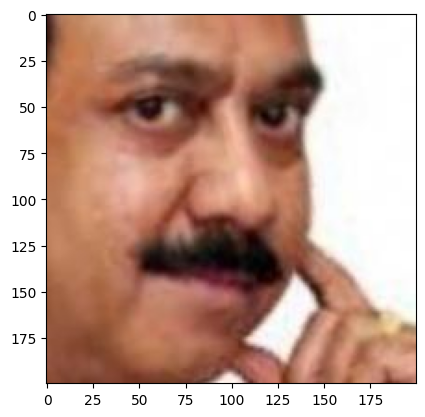

In [28]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open('/content/utkface_aligned_cropped/UTKFace/'+df['img_path'][0])
plt.imshow(img)

In [35]:
from keras.preprocessing.image import load_img
x_train = []
for file in df['img_path']:
  img = load_img('/content/utkface_aligned_cropped/UTKFace/'+ file).convert('RGB')
  img = img.resize((224,224))
  img = np.array(img)
  x_train.append(img)
x_train = np.array(x_train)
x_train = x_train.reshape(len(x_train),224,224,3  )

In [36]:
x_train.shape

(23708, 224, 224, 3)

In [37]:
y_gender = np.array(df.gender)
y_age = np.array(df.age)
y_race = np.array(df.race)

In [39]:
# from tensorflow.keras.utils import to_categorical

# # แปลง race ให้เป็น one-hot encoding
# y_race = to_categorical(y_race, num_classes=5)
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Suppose y_race contains string labels
y_race = ['race1', 'race2', 'race1', 'race3']  # Example labels

# Step 1: Convert string labels to integers
label_encoder = LabelEncoder()
y_race_int = label_encoder.fit_transform(y_race)

# Step 2: Convert integer labels to one-hot encoding
y_race_onehot = to_categorical(y_race_int, num_classes=5)

print(y_race_onehot)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [40]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.initializers import glorot_uniform

In [41]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the VGG16 layers
for layer in conv_base.layers:
    layer.trainable = False

# Input layer
input_size = (224, 224, 3)
inputs = Input(input_size)

# Apply the VGG16 base model
X = conv_base(inputs)

# Flatten the output
X = Flatten()(X)
# Dense layers for shared representation
dense_1 = Dense(256, activation='relu')(X)
dropout_1 = Dropout(0.4)(dense_1)

# Dense layers specific to each task
dense_2 = Dense(256, activation='relu')(X)
dropout_2 = Dropout(0.4)(dense_2)

dense_3 = Dense(128, activation='relu')(X)
dropout_3 = Dropout(0.4)(dense_3)

# Output layers
output_1 = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)  # Gender output
output_2 = Dense(1, activation='linear', name='age_output')(dropout_2)      # Age output
output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)    # Race output

model = Model(inputs=inputs, outputs=[output_1, output_2, output_3])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25088)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      6,422,784 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │      6,422,784 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │      3,211,392 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_output (Dense)     │ (None, 1)              │            257 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_output (Dense)        │ (None, 1)              │            257 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ race_output (Dense)       │ (None, 5)              │            645 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 30,772,807 (117.39 MB)

 Trainable params: 16,058,119 (61.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [42]:
model.compile(
    optimizer='adam',
    loss={
        'gender_output': 'binary_crossentropy',
        'age_output': 'mean_squared_error',
        'race_output': 'categorical_crossentropy'
    },
    metrics={
        'gender_output': 'accuracy',
        'age_output': 'mean_absolute_error',
        'race_output': 'accuracy'
    }
)

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback to save the model with the best 'race_output' performance
checkpoint = ModelCheckpoint(
    'best_model_by_race_output.keras',  # Path where the best model will be saved
    monitor='val_race_output_loss',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='min',  # Mode for the metric: 'min' for loss
    verbose=1  # Verbosity level
)

In [ ]:
history = model.fit(
    x_train,
    {
        'gender_output': y_gender,
        'age_output': y_age,
        'race_output': y_race
    },
    epochs=20,  # Set the number of epochs as needed
    batch_size=32,  # Set the batch size as needed
    validation_split=0.1,  # Use a validation split or provide validation data
    callbacks=[checkpoint]  # Add the checkpoint callback
)

In [14]:
!pip install split-folders

In [38]:
# train_data = df.sample(frac=1,random_state=0).iloc[:20000]
# test_data = df.sample(frac=1,random_state= 0).iloc[20000:]
#this is alternative option for update the train and test foler with the help of splitfolders
import splitfolders
splitfolders.ratio(folder, output="data", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 33488 files [00:06, 5450.22 files/s]


In [16]:
#print(train_data.shape, test_data.shape)

NameError: name 'train_data' is not defined

In [39]:
train_data = ImageDataGenerator(rescale=1./255,
                                horizontal_flip = True,
                                rotation_range= .10,
                                zoom_range = .20,

                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2
                                  )
test_data = ImageDataGenerator(rescale=1./255)


In [50]:
train_dir = '/content/data/train/'
train_gen = train_data.flow_from_directory(directory = train_dir,
                                           target_size= (200,200),
                                           batch_size= 16,
                                           class_mode = 'sparse'
                                           )

test_dir = '/content/data/test/'
test_gen = test_data.flow_from_directory(directory = test_dir,
                                           target_size= (200,200),
                                           batch_size= 16,
                                           class_mode = 'sparse'
                                           )
valid_dir = '/content/data/val/'
valid_gen = test_data.flow_from_directory(directory = valid_dir,
                                           target_size= (200,200),
                                           batch_size= 16,
                                          class_mode = 'sparse'
                                        )

Found 26790 images belonging to 2 classes.
Found 3350 images belonging to 2 classes.
Found 3348 images belonging to 2 classes.


In [41]:
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model

In [51]:
resnet = ResNet50(include_top=False, input_shape=(200,200,3))

In [43]:
resnet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
tst = resnet.layers[-1].output

In [70]:
resnet = ResNet50(include_top=False, input_shape=(200,200,3))

resnet.trainable=False

output = resnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(128, activation='relu')(flatten)
doc_controls = Dropout(0.5)(dense1)
dense2 = Dense(128,activation='relu')(flatten)
doc_controls2 = Dropout(0.5)(dense2)

dense3 = Dense(128,activation='relu')(flatten)
doc_controls3 = Dropout(0.5)(dense3)
# dense4 = Dense(128,activation='relu')(dense1)
# dense5 = Dense(128,activation='relu')(dense2)
# dense6 = Dense(128,activation='relu')(dense3)


output1 = Dense(1,activation = 'softmax',name='race')(doc_controls)
output2 = Dense(1,activation='sigmoid',name='gender')(doc_controls2)

output3 = Dense(1,activation='linear',name='age')(doc_controls3)

model = Model(inputs=resnet.input, outputs=[output1,output2,output3])

In [71]:
model.compile(optimizer='adam', loss={'race':'categorical_crossentropy','age': 'mae', 'gender': 'binary_crossentropy'}, metrics={'race':'accuracy','age': 'mae', 'gender': 'accuracy'})
#,loss_weights={'age':99.0,'gender':1.0,'race':5.0})


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback to save the model with the best 'race_output' performance
checkpoint = ModelCheckpoint(
    'best_model_by_race_output.h5',  # Path where the best model will be saved
    monitor='val_race_output_loss',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='min',  # Mode for the metric: 'min' for loss
    verbose=1  # Verbosity level
)

In [ ]:
model.fit(train_gen, batch_size=16, epochs=5, validation_data=test_gen)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (16, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(16, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **se

   1/1675 ━━━━━━━━━━━━━━━━━━━━ 45:08 2s/step - loss: 0.0000e+00 - race_accuracy: 0.1875

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


1031/1675 ━━━━━━━━━━━━━━━━━━━━ 6:01 561ms/step - loss: 0.0000e+00 - race_accuracy: 0.2942

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (6, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(6, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


1675/1675 ━━━━━━━━━━━━━━━━━━━━ 1014s 605ms/step - loss: 0.0000e+00 - race_accuracy: 0.2935 - val_loss: 0.0000e+00 - val_race_accuracy: 0.2919
Epoch 2/5
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 988s 573ms/step - loss: 0.0000e+00 - race_accuracy: 0.2929 - val_loss: 0.0000e+00 - val_race_accuracy: 0.2919
Epoch 3/5
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 970s 566ms/step - loss: 0.0000e+00 - race_accuracy: 0.2927 - val_loss: 0.0000e+00 - val_race_accuracy: 0.2919
Epoch 4/5
 359/1675 ━━━━━━━━━━━━━━━━━━━━ 11:42 534ms/step - loss: 0.0000e+00 - race_accuracy: 0.2883